<a href="https://colab.research.google.com/github/sarahaptumich/capstone/blob/shaptonstall/brace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Mount google drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github/capstone/brace

/content/drive/MyDrive/Github/capstone/brace


In [3]:
%ls

 annotations/      dataset/             lstm_model2.pth         tensor_dataset.pkl
 bracedataset.py   dataset_pytorch.py   lstm_model.pth          test_subset.pkl
 brace_test.pkl    figures/            'MODELS ACCURACY.gdoc'   train_subset.pkl
 brace_test.pth    keras_model/         path/                   utils/
 brace_train.pkl   k_model_features/    __pycache__/            videos_info.csv
 brace_train.pth   k_model_features2/   README.md


In [4]:
# !nvidia-smi

In [5]:
import sys
sys.path.append('/content/drive/MyDrive/Github/capstone/brace')

In [6]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch import nn, optim
import bracedataset
from pathlib import Path
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import TensorDataset
from tqdm import tqdm
from pathlib import PosixPath
import pickle
import re
import torch.nn.functional as F
from torch.utils.data import TensorDataset, random_split
from torch.optim.lr_scheduler import ExponentialLR
import json
from pathlib import Path

In [7]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping

Obtain BRACE dataset clips and labels, only need to to this once, they are saved for future reference


In [8]:
# #load paths
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# #get max length of the keypoints
# max_length = max(seq.shape[0] for seq in dataClips)

# #pad tensor so they are of the same lenght
# dataClips_tensors=[np.pad(array.astype(np.float32), ((0, max_length - array.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=0) for array in dataClips]
# dataClips_tensors=torch.tensor(dataClips_tensors)
# #convert labels to tensors
# label_tensors = np.array(encoded_categories)
# label_tensors=torch.tensor(label_tensors)
# ##SPLIT SET FOR REPRODUCTIVITY
# dataset = TensorDataset(dataClips_tensors, label_tensors)
# # Set seed for reproducibility
# torch.manual_seed(42)

# # Determine split sizes
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size

# # Split dataset
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# print(f"Training set size: {len(train_dataset)}")
# print(f"Testing set size: {len(test_dataset)}")
# # Save the TensorDataset
# with open('tensor_dataset.pkl', 'wb') as f:
#     pickle.dump(dataset, f)

# # Save the Subset
# with open('train_subset.pkl', 'wb') as f:
#     pickle.dump(train_dataset, f)
# with open('test_subset.pkl', 'wb') as f:
#     pickle.dump(test_dataset, f)

Load previously saved dataset

In [9]:
# Load the TensorDataset
with open('tensor_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

# Load the training Subset
with open('train_subset.pkl', 'rb') as f:
    train_dataset = pickle.load(f)

# Load the testing Subset
with open('test_subset.pkl', 'rb') as f:
    test_dataset = pickle.load(f)

In [10]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Use this to load the dataset

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes=3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
# Initialize the model
input_size = 17 * 2
hidden_size = 128
num_layers = 2
num_classes = 3

model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10
for epoch in range(num_epochs):

    for sequences, labels in train_loader:
        sequences = sequences.to(device).view(-1, 1280, 34)  # Adjust shape for LSTM
        labels = labels.to(device)

        # Forward pass
        outputs = model(sequences)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
# model_path = "lstm_model2.pth"
# torch.save(model.state_dict(), model_path)
# print(f"Model saved to {model_path}")

In [ ]:
# model = LSTMModel(input_size, hidden_size, num_layers, num_classes).to(device)
# model.load_state_dict(torch.load(model_path))


# print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
correct = 0
total = 0
model.eval()
with torch.no_grad():
    for sequences, labels in test_loader:
        sequences = sequences.to(device).view(-1, 1280, 34)
        labels = labels.to(device)
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the test dataset: {accuracy:.2f}%')
#accuracy 33.85%

CNN model with RNN layer


In [11]:
# #load paths
# sequences_path = Path('/content/drive/MyDrive/Github/capstone/brace/dataset')
# pose_jsons = list(Path(sequences_path).rglob('**/*.json'))
# segments= pd.read_csv(Path('/content/drive/MyDrive/Github/capstone/brace/annotations/segments.csv'))
# #get clips
# dataClips, labels, names=bracedataset.BraceDataset(segments, pose_jsons)
# #encode labels from 0-2
# unique_categories = list(set(labels))
# category_to_int = {category: index for index, category in enumerate(unique_categories)}
# encoded_categories = [category_to_int[category] for category in labels]

# with open("dataClips", "wb") as fp:   #Pickling
#     pickle.dump(dataClips, fp)
# with open("labels", "wb") as fp:   #Pickling
#     pickle.dump(labels, fp)
# with open("names", "wb") as fp:   #Pickling
#     pickle.dump(names, fp)


In [21]:
# # Load the TensorDataset
# with open('dataClips', 'rb') as f:
#     dataClips = pickle.load(f)

# # Load the training Subset
# with open('labels', 'rb') as f:
#     labels = pickle.load(f)

# # Load the testing Subset
# with open('names', 'rb') as f:
#     names = pickle.load(f)

In [58]:
flattened_clips = [clip.reshape(clip.shape[0], -1) for clip in dataClips]

padded_clips = pad_sequences(flattened_clips, padding='post', dtype='float32')


In [ ]:
### KERAS CNN MODEL######

X_train, X_test, y_train, y_test = train_test_split(
    padded_clips, encoded_categories, test_size=0.20, random_state=42)
# Convert labels to one-hot encoding
y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Define the model
model = Sequential([
    LSTM(50, input_shape=(padded_clips.shape[1], padded_clips.shape[2])),
    Dense(100, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
history = model.fit(X_train, y_train_onehot, epochs=10, batch_size=32, validation_split=0.2)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                17000     
                                                                 
 dense (Dense)               (None, 100)               5100      
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 303       
                                                                 
Total params: 22403 (87.51 KB)
Trainable params: 22403 (87.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
27/27 [==============================] - 18s 536ms/step - loss: 1.0997 - accuracy: 0.3113 - val_loss: 1.0991 - val_accuracy: 0.2949
Epoch 2/1

In [ ]:
# model.save('/content/drive/MyDrive/Github/capstone/brace/keras_model')
# Load the model
loaded_model = load_model('path/to/location/keras_model')

# test
test_loss, test_accuracy = loaded_model.evaluate(X_test, y_test_onehot)
print(f'Test Accuracy: {test_accuracy}')

9/9 [==============================] - 2s 131ms/step - loss: 1.0955 - accuracy: 0.3616
Test Accuracy: 0.361623615026474


INCLUDE FEATURES IN THE MODEL

In [59]:
#sort additional features
features= segments.copy()
features['uid']= pd.Categorical(features['uid'], categories=names, ordered=True)
features= features.sort_values(by='uid')
features['frames']= features['end_frame']- features['start_frame']


In [61]:
# One-hot encode
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('cat', OneHotEncoder(), ['dancer_id']),
        ('num', OneHotEncoder(), ['year']),

    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'dancer_id', 'year']])
features_preprocessed = features_preprocessed.toarray()
features_preprocessed[0]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [62]:
# split train, test
X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

In [63]:
# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50)(keypoint_input)
keypoint_model = Dense(100, activation='relu')(keypoint_model)

# Additional features input branch
additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu')(additional_features_input)

# Concatenate the outputs of the two branches
combined = concatenate([keypoint_model, features_model])

# Add a classification layer
combined = Dense(100, activation='relu')(combined)
combined = Dropout(0.5)(combined)
output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# Build the model
model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 1280, 34)]           0         []                            
 )                                                                                                
                                                                                                  
 lstm (LSTM)                 (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 78)]                 0         []                            
 )                                                                                                
                                                                                              

In [64]:
history = model.fit([X_train_clips, X_train_features], y_train_onehot, validation_split=0.2, epochs=10, batch_size=32)

Epoch 1/10
27/27 [==============================] - 18s 543ms/step - loss: 1.0998 - accuracy: 0.3414 - val_loss: 1.1071 - val_accuracy: 0.3041
Epoch 2/10
27/27 [==============================] - 10s 359ms/step - loss: 1.0954 - accuracy: 0.3519 - val_loss: 1.1055 - val_accuracy: 0.3318
Epoch 3/10
27/27 [==============================] - 11s 417ms/step - loss: 1.0825 - accuracy: 0.4155 - val_loss: 1.1165 - val_accuracy: 0.3226
Epoch 4/10
27/27 [==============================] - 12s 432ms/step - loss: 1.0833 - accuracy: 0.4120 - val_loss: 1.1128 - val_accuracy: 0.3088
Epoch 5/10
27/27 [==============================] - 12s 432ms/step - loss: 1.0713 - accuracy: 0.4306 - val_loss: 1.1167 - val_accuracy: 0.3134
Epoch 6/10
27/27 [==============================] - 11s 415ms/step - loss: 1.0555 - accuracy: 0.4630 - val_loss: 1.1219 - val_accuracy: 0.3134
Epoch 7/10
27/27 [==============================] - 10s 388ms/step - loss: 1.0554 - accuracy: 0.4606 - val_loss: 1.1293 - val_accuracy: 0.3226

In [65]:
model.save('/content/drive/MyDrive/Github/capstone/brace/k_model_features')
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Github/capstone/brace/k_model_features')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}") #0.31

9/9 [==============================] - 1s 118ms/step - loss: 1.1632 - accuracy: 0.3247
Test Loss: 1.1632002592086792
Test Accuracy: 0.3247232437133789


CHANGE FEATURES TO SEQUENCE AND CLIP LENGHT, TO TEST IF THERE IS LESS OVERFITTING

In [66]:
# One-hot encode
preprocessor = ColumnTransformer(
    transformers=[
        ('seq', OneHotEncoder(), ['seq_idx']),
        ('frames', OneHotEncoder(), ['frames'])
    ]
)

features_preprocessed = preprocessor.fit_transform(features[['seq_idx', 'frames']])
features_preprocessed = features_preprocessed.toarray()
features_preprocessed.shape

(1352, 505)

In [ ]:
# #### KERAS FEATURE MODEL2#####

# X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
#     padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


# y_train_onehot = to_categorical(y_train, num_classes=3)
# y_test_onehot = to_categorical(y_test, num_classes=3)

# # Keypoint input branch
# keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
# keypoint_model = LSTM(50)(keypoint_input)
# keypoint_model = Dense(100, activation='relu')(keypoint_model)

# # Additional features input branch
# additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
# features_model = Dense(50, activation='relu')(additional_features_input)

# # Concatenate the outputs of the two branches
# combined = concatenate([keypoint_model, features_model])

# # Add a classification layer
# combined = Dense(100, activation='relu')(combined)
# combined = Dropout(0.5)(combined)
# output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# # Build the model
# model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# # Compile the model
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Model summary to check architecture
# model.summary()

In [67]:

X_train_clips, X_test_clips, X_train_features, X_test_features, y_train, y_test = train_test_split(
    padded_clips, features_preprocessed, encoded_categories, test_size=0.2, random_state=42)


y_train_onehot = to_categorical(y_train, num_classes=3)
y_test_onehot = to_categorical(y_test, num_classes=3)

# Keypoint input branch
keypoint_input = Input(shape=(X_train_clips.shape[1], X_train_clips.shape[2]), name='keypoint_input')
keypoint_model = LSTM(50, recurrent_regularizer=l1_l2(l1=0.01, l2=0.01))(keypoint_input)  # Adding regularization to LSTM
keypoint_model = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(keypoint_model)  # Adding regularization
keypoint_model = Dropout(0.5)(keypoint_model)  # Adding dropout

# Additional features input branch
additional_features_input = Input(shape=(X_train_features.shape[1],), name='features_input')
features_model = Dense(50, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(additional_features_input)  # Adding regularization
features_model = Dropout(0.5)(features_model)  # Adding dropout

# Concatenate the outputs of the two branches
combined = concatenate([keypoint_model, features_model])

# Add a classification layer
combined = Dense(100, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))(combined)  # Adding regularization
combined = Dropout(0.5)(combined)  # Adding dropout
output = Dense(3, activation='softmax')(combined)  # Assuming 3 classes

# Build the model
model = Model(inputs=[keypoint_input, additional_features_input], outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary to check architecture
model.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 keypoint_input (InputLayer  [(None, 1280, 34)]           0         []                            
 )                                                                                                
                                                                                                  
 lstm_1 (LSTM)               (None, 50)                   17000     ['keypoint_input[0][0]']      
                                                                                                  
 features_input (InputLayer  [(None, 505)]                0         []                            
 )                                                                                                
                                                                                            

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model with early stopping
history = model.fit(
    [X_train_clips, X_train_features], y_train_onehot,
    validation_data=([X_test_clips, X_test_features], y_test_onehot),
    epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
34/34 [==============================] - 28s 714ms/step - loss: 30.7461 - accuracy: 0.3358 - val_loss: 22.2211 - val_accuracy: 0.3542
Epoch 2/100
34/34 [==============================] - 34s 1s/step - loss: 16.2763 - accuracy: 0.3525 - val_loss: 10.8972 - val_accuracy: 0.3616
Epoch 3/100
34/34 [==============================] - 20s 597ms/step - loss: 7.5851 - accuracy: 0.3228 - val_loss: 4.8566 - val_accuracy: 0.3616
Epoch 4/100
34/34 [==============================] - 24s 686ms/step - loss: 3.4924 - accuracy: 0.3321 - val_loss: 2.3563 - val_accuracy: 0.3616
Epoch 5/100
34/34 [==============================] - 29s 856ms/step - loss: 1.8171 - accuracy: 0.3191 - val_loss: 1.4518 - val_accuracy: 0.3616
Epoch 6/100
34/34 [==============================] - 29s 866ms/step - loss: 1.3050 - accuracy: 0.3599 - val_loss: 1.2047 - val_accuracy: 0.3616
Epoch 7/100
34/34 [==============================] - 25s 733ms/step - loss: 1.1854 - accuracy: 0.3377 - val_loss: 1.1714 - val_accuracy

In [ ]:
model.save('/content/drive/MyDrive/Github/capstone/brace/k_model_features3')
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Github/capstone/brace/k_model_features3')

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate([X_test_clips, X_test_features], y_test_onehot)
print(f"Model name: {loaded_model}")
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

9/9 [==============================] - 1s 137ms/step - loss: 1.3042 - accuracy: 0.3321
Test Loss: 1.304213285446167
Test Accuracy: 0.33210331201553345


Try Dynamic Time Warping


In [23]:
pip install dtaidistance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.1 MB/s eta 0:00:00


In [101]:
from dtaidistance import dtw
from dtaidistance import dtw
from dtaidistance import clustering
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [73]:
dtw_means=[]
for i in dataClips:
    data=i
    data_flattened = [clip.reshape(clip.shape[0], -1) for clip in data]
    distance_matrix = dtw.distance_matrix_fast(data_flattened)
    mean_dist=distance_matrix.mean()
    dtw_means.append(mean_dist)

In [74]:
len(dtw_means)


1352

Clustering with Dynamic Time Warping

In [107]:
cluster_df=features[['seq_idx', 'frames']].copy()
cluster_df['dtw']= pd.Series(dtw_means)
cluster_df.shape

(1352, 3)

In [108]:
scaler = StandardScaler()
clusters_scaled = scaler.fit_transform(cluster_df)
pca = PCA(n_components=2)
clusters_pca = pca.fit_transform(clusters_scaled)
pca_df = pd.DataFrame(data=clusters_pca, columns=['Principal Component 1', 'Principal Component 2'])

In [119]:
kmeans = KMeans(n_clusters=3, random_state=42)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['Principal Component 1', 'Principal Component 2']])
pca_df['ActualLabels'] = encoded_categories

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


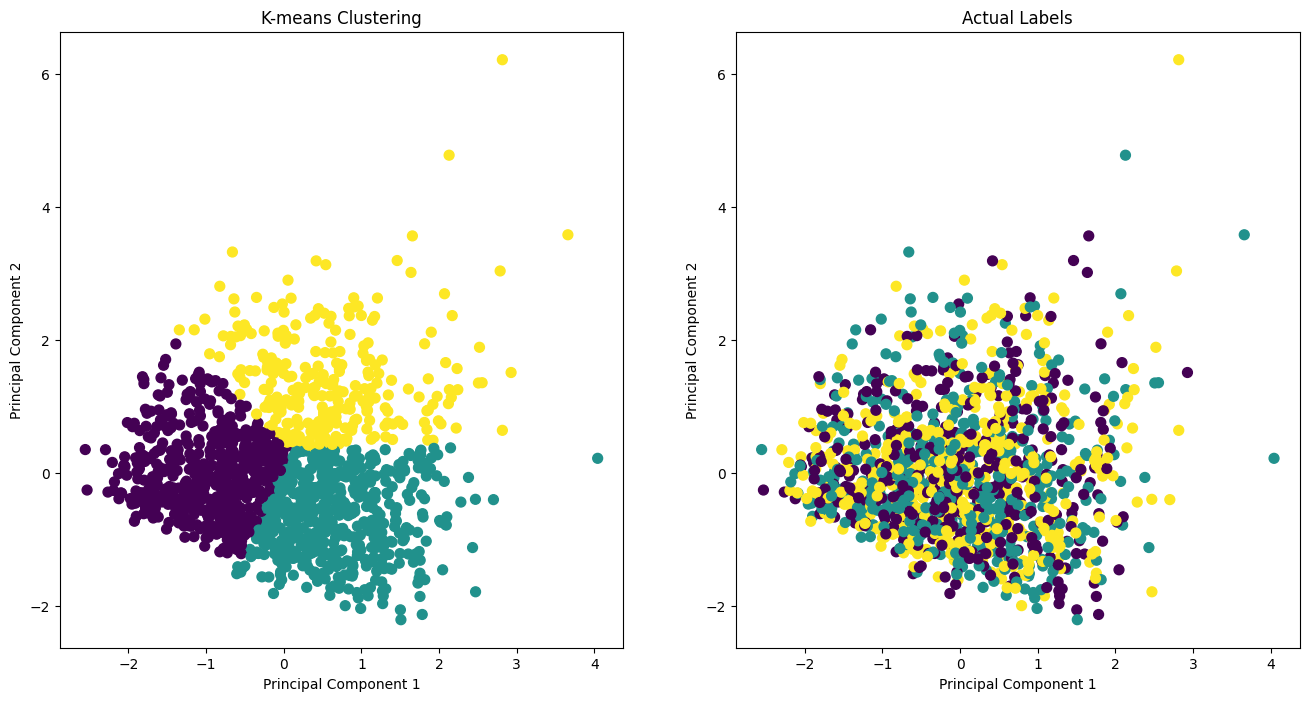

In [121]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# K-means Cluster Plot
ax[0].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['Cluster'], cmap='viridis', s=50)
ax[0].set_title('K-means Clustering')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

# Actual Labels Plot
ax[1].scatter(pca_df['Principal Component 1'], pca_df['Principal Component 2'], c=pca_df['ActualLabels'], cmap='viridis', s=50)
ax[1].set_title('Actual Labels')
ax[1].set_xlabel('Principal Component 1')
ax[1].set_ylabel('Principal Component 2')

plt.show()